In [57]:
!pip install wordcloud

In [91]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
import scipy.sparse as sp

# NLP and Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# WordCloud
from wordcloud import WordCloud

# Scikit-learn Modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, log_loss

# Pipeline Saving
import joblib

# Download NLTK Data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Setting up Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gauta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gauta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gauta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [93]:
# Loading Dataset
logging.info("Loading dataset...")
df = pd.read_csv("hate_speech_and_offensive_language_dataset.csv")  
logging.info("Dataset loaded successfully.")
display(df.head())

2025-01-25 23:02:40,667 - INFO - Loading dataset...
2025-01-25 23:02:40,776 - INFO - Dataset loaded successfully.


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [95]:
# Dataset Information
logging.info("Displaying dataset information...")
print(df.info())

2025-01-25 23:02:41,903 - INFO - Displaying dataset information...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None


In [97]:
# Handling Missing Values
logging.info("Handling missing values...")

# Dropping rows where 'tweet' is NaN
initial_shape = df.shape
df.dropna(subset=['tweet'], inplace=True)
logging.info(f"Dropped {initial_shape[0] - df.shape[0]} rows with missing tweets.")

# Filling missing numeric values with median
numeric_cols = ['count', 'hate_speech', 'offensive_language', 'neither']
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        logging.info(f"Filled missing values in '{col}' with median value {median_val}.")

# Checking remaining missing values
remaining_missing = df.isnull().sum()
print("Remaining Missing Values:")
print(remaining_missing)

# Visualization Placeholder
# Table 1: Missing Values Before and After Handling
missing_before = pd.read_csv("hate_speech_and_offensive_language_dataset.csv").isnull().sum()
missing_after = df.isnull().sum()
missing_df = pd.DataFrame({'Before': missing_before, 'After': missing_after})
print(missing_df)

2025-01-25 23:02:42,998 - INFO - Handling missing values...
2025-01-25 23:02:43,024 - INFO - Dropped 0 rows with missing tweets.


Remaining Missing Values:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64
                    Before  After
Unnamed: 0               0      0
count                    0      0
hate_speech              0      0
offensive_language       0      0
neither                  0      0
class                    0      0
tweet                    0      0


In [99]:
# censoring offensive words for report

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Defining the censorship dictionary
censor_map = {
    "nigger": "n****r",
    "niggers": "n****rs",
    "nigga":  "n****",
    "faggot": "f****t",
    "fag":    "f**",
    "bitch":  "b***h",
    "fuck":   "f**k",
    "shit":   "s**t",
    "pussy":  "p***y",
    "whore":  "w***e",
    "cunt":   "c**t",
    "niggas": "n****s",
    "bitches": "b***hes",
    "fucking": "f**king",
    "faggots": "f****ts",
    "retard": "r****d",
    "retarded": "r****ded",
    "hoe": "h**",
    "dyke": "d***e",
    "beaner": "b*****r",
    "coon": "c**n"
    
}

def censor_text_regex(text, censor_map):
    """
    Censors offensive words in the input text based on the provided censor_map.

    Parameters:
    - text (str): The input string to censor.
    - censor_map (dict): A dictionary mapping offensive words to their censored versions.

    Returns:
    - str: The censored text.
    """
    for word, replacement in censor_map.items():
        # Create a regex pattern to match the exact word, case-insensitive
        pattern = re.compile(r'\b' + re.escape(word) + r'\b', re.IGNORECASE)
        text = pattern.sub(replacement, text)
    return text


data = {
    'tweet': [
        "You are a fucking idiot!",
        "I love sunny days.",
        "What a b****h!",
        "This is a lovely day.",
        "Go to hell, you pussy!",
        "Faggot behavior is unacceptable.",
        "Such a shitty experience.",
        "You're a whore and a bitch.",
        "No offensive words here.",
        "Cunt behavior detected."
    ],
    'class': [0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
    'likes': [10, 50, 5, 40, 3, 2, 1, 4, 30, 2],
    'retweets': [2, 15, 1, 12, 0, 0, 0, 1, 10, 0]
}

df = pd.DataFrame(data)


df = pd.read_csv('hate_speech_and_offensive_language_dataset.csv')

# Converting 'class' column to numeric, handling non-convertible values
df['class'] = pd.to_numeric(df['class'], errors='coerce').fillna(-1).astype(int)

# Checking for any rows where 'class' was not converted properly
invalid_classes = df[df['class'] == -1]
if not invalid_classes.empty:
    logging.warning("Some rows have invalid 'class' values and have been set to -1.")
   

# Feature Engineering: Add tweet_length and num_offensive_words
def count_offensive_words(text, censor_map):
    """
    Counts the number of offensive words in the input text based on the censor_map.

    Parameters:
    - text (str): The input string to analyze.
    - censor_map (dict): A dictionary mapping offensive words to their censored versions.

    Returns:
    - int: The count of offensive words found in the text.
    """
    count = 0
    for word in censor_map.keys():
        pattern = re.compile(r'\b' + re.escape(word) + r'\b', re.IGNORECASE)
        matches = pattern.findall(text)
        count += len(matches)
    return count

df['tweet_length'] = df['tweet'].apply(len)
df['num_offensive_words'] = df['tweet'].apply(lambda x: count_offensive_words(x, censor_map))

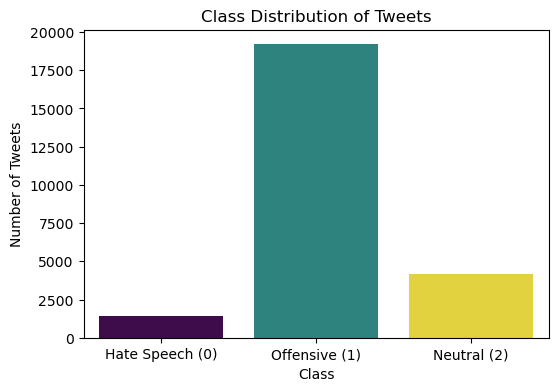

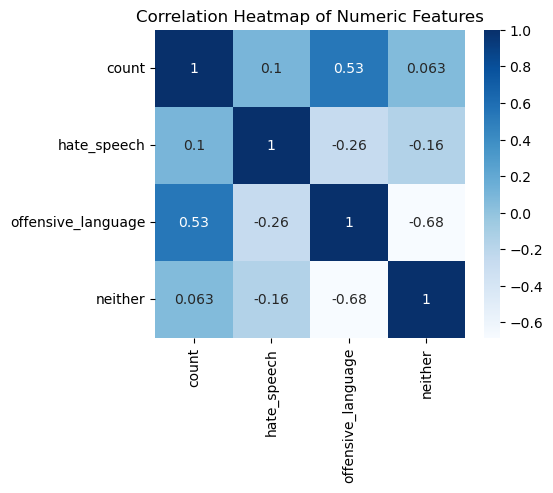

2025-01-25 23:02:50,630 - INFO - Generating censored Word Cloud for hateful tweets (class=0).


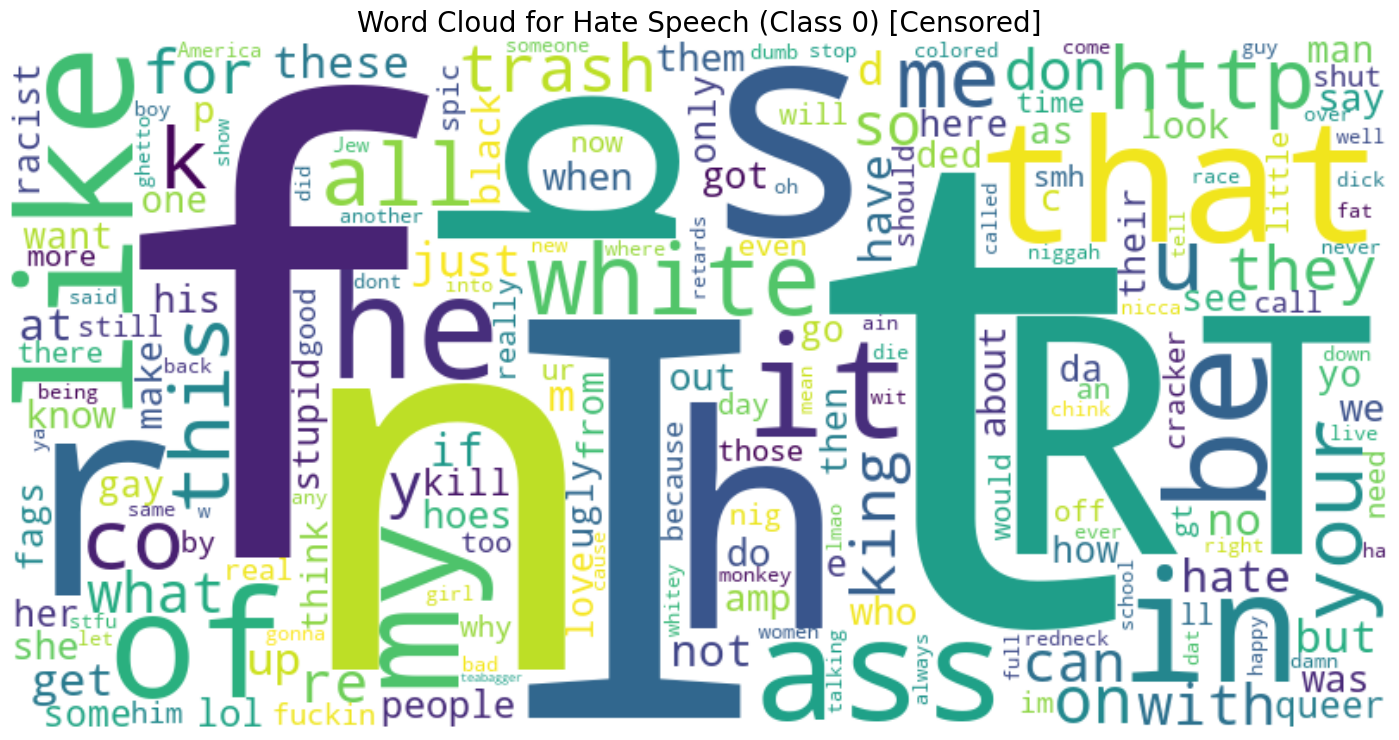

In [100]:
#  Exploratory Data Analysis (EDA)

# Suppress INFO log messages from Seaborn and Matplotlib
logging.getLogger('seaborn').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

#Class Distribution

# Ensureing 'class' column is numeric
df['class'] = pd.to_numeric(df['class'], errors='coerce').astype(int)

# Visualization: Class Distribution Bar Chart
plt.figure(figsize=(6, 4))
sns.countplot(
    x='class',
    hue='class',       # Assigning hue to 'class' to comply with palette usage
    data=df,
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title("Class Distribution of Tweets")
plt.xlabel("Class")
plt.ylabel("Number of Tweets")
plt.xticks(
    ticks=[0, 1, 2],
    labels=['Hate Speech (0)', 'Offensive (1)', 'Neutral (2)']
)
plt.show()

# Correlation Heatmap of Numeric Features
plt.figure(figsize=(5,4))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='Blues')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

#  Word Cloud for Hateful Tweets (Class 0) with Censorship
logging.info("Generating censored Word Cloud for hateful tweets (class=0).")

# Filtering tweets for class 0 (hateful content)
hate_texts = df[df['class'] == 0]['tweet']

# Joining all hateful tweets into a single string
joined_text = " ".join(hate_texts)

# Censoring offensive words in the joined text
joined_text_censored = censor_text_regex(joined_text, censor_map)

# Generateing the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False,          # Prevents joining of bigrams
    stopwords=set(['and', 'or', 'the', 'is', 'a', 'are', 'to', 'you']),  # Adding additional stopwords if needed
    regexp=r'\w+'                # Ensures that words with censored characters are included
).generate(joined_text_censored)

# Display the word cloud
plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Hate Speech (Class 0) [Censored]", fontsize=20)
plt.tight_layout()
plt.show()

In [101]:
# Outlier Detection and Handling using IQR

logging.info("Detecting and handling outliers using the IQR method...")

def iqr_cap(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return series.clip(lower_bound, upper_bound)

# Applying IQR capping to numeric columns
for col in numeric_cols:
    before_capping = df[col].copy()
    df[col] = iqr_cap(df[col], factor=1.5)
    num_capped = (before_capping != df[col]).sum()
    if num_capped > 0:
        logging.info(f"Capped {num_capped} outliers in '{col}'.")

# Table 2: Numeric Features Before and After IQR Capping
before_stats = pd.read_csv("hate_speech_and_offensive_language_dataset.csv")[numeric_cols].describe()
after_stats = df[numeric_cols].describe()
comparison = pd.concat([before_stats, after_stats], axis=1, keys=['Before', 'After'])
print(comparison)

2025-01-25 23:02:53,138 - INFO - Detecting and handling outliers using the IQR method...
2025-01-25 23:02:53,147 - INFO - Capped 1976 outliers in 'count'.
2025-01-25 23:02:53,158 - INFO - Capped 4993 outliers in 'hate_speech'.
2025-01-25 23:02:53,171 - INFO - Capped 4837 outliers in 'offensive_language'.
2025-01-25 23:02:53,180 - INFO - Capped 5891 outliers in 'neither'.


             Before                                                   After  \
              count   hate_speech offensive_language       neither    count   
count  24783.000000  24783.000000       24783.000000  24783.000000  24783.0   
mean       3.243473      0.280515           2.413711      0.549247      3.0   
std        0.883060      0.631851           1.399459      1.113299      0.0   
min        3.000000      0.000000           0.000000      0.000000      3.0   
25%        3.000000      0.000000           2.000000      0.000000      3.0   
50%        3.000000      0.000000           3.000000      0.000000      3.0   
75%        3.000000      0.000000           3.000000      0.000000      3.0   
max        9.000000      7.000000           9.000000      9.000000      3.0   

                                               
      hate_speech offensive_language  neither  
count     24783.0       24783.000000  24783.0  
mean          0.0           2.403966      0.0  
std           0.0

In [102]:
#Feature Engineering
# Cleaning and Preprocessing

logging.info("Cleaning text: removing punctuation, URLs, stopwords, lemmatizing...")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(txt):
    txt = txt.lower()  # Lowercase
    txt = re.sub(r"http\S+|www\S+|https\S+", '', txt)  # Remove URLs
    txt = re.sub(r"[^\w\s]", '', txt)  # Remove punctuation
    tokens = txt.split()  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return " ".join(tokens)

df['clean_tweet'] = df['tweet'].apply(clean_text)

# Displaying cleaned tweets
logging.info("Sample of cleaned tweets:")
display(df[['tweet', 'clean_tweet']].head())

2025-01-25 23:02:53,331 - INFO - Cleaning text: removing punctuation, URLs, stopwords, lemmatizing...
2025-01-25 23:02:56,170 - INFO - Sample of cleaned tweets:


,tweet,clean_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely woman shouldnt complain cleani...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew17 boy dat coldtyga dwn bad cuffin dat...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt c_g_anderson viva_based look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts shit hear might true might f...


2025-01-25 23:02:56,208 - INFO - Performing TF-IDF vectorization on cleaned tweets...
2025-01-25 23:02:57,061 - INFO - TF-IDF matrix shape: (24783, 5000)


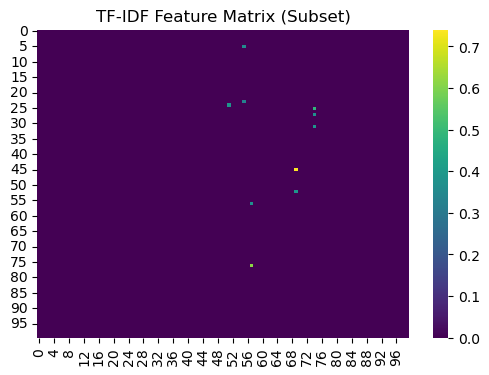

In [103]:
# TF-IDF Vectorization

logging.info("Performing TF-IDF vectorization on cleaned tweets...")

tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['clean_tweet'])

logging.info(f"TF-IDF matrix shape: {X_text.shape}")

# TF-IDF Feature Matrix Sparsity (Subset)
plt.figure(figsize=(6,4))
sns.heatmap(X_text[:100, :100].todense(), cmap='viridis')  # Visualizing a subset for readability
plt.title("TF-IDF Feature Matrix (Subset)")
plt.show()

In [109]:
# Combining TF-IDF with Numeric Features

logging.info("Combining TF-IDF vectors with numeric features...")

from scipy.sparse import hstack

# Converting numeric columns to sparse matrix
X_numeric = sp.csr_matrix(df[numeric_cols].values)

# Combining TF-IDF and numeric features horizontally
X_combined = hstack([X_text, X_numeric])

logging.info(f"Combined feature matrix shape: {X_combined.shape}")

# Shape of Combined Features
print(f"TF-IDF Features: {X_text.shape}")
print(f"Numeric Features: {X_numeric.shape}")
print(f"Combined Features: {X_combined.shape}")

2025-01-25 23:03:05,393 - INFO - Combining TF-IDF vectors with numeric features...
2025-01-25 23:03:05,404 - INFO - Combined feature matrix shape: (24783, 5004)


TF-IDF Features: (24783, 5000)
Numeric Features: (24783, 4)
Combined Features: (24783, 5004)


2025-01-25 23:03:17,996 - INFO - Applying Truncated SVD for dimensionality reduction...
2025-01-25 23:03:19,568 - INFO - Reduced feature matrix shape: (24783, 100)


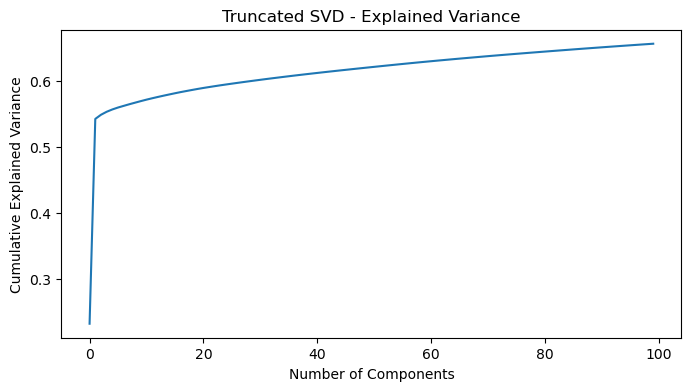

In [111]:
# Dimensionality Reduction using Truncated SVD

logging.info("Applying Truncated SVD for dimensionality reduction...")

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_combined)

logging.info(f"Reduced feature matrix shape: {X_reduced.shape}")

# Explained Variance Ratio
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Truncated SVD - Explained Variance')
plt.show()

In [113]:
#Model Selection and Training

# Splitting Data into Train, Validation, and Test Sets

logging.info("Splitting data into Train, Validation, and Test sets (80-10-10)...")

X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, df['class'].values, test_size=0.2, random_state=42, stratify=df['class'].values
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

logging.info(f"Train set shape: {X_train.shape}")
logging.info(f"Validation set shape: {X_val.shape}")
logging.info(f"Test set shape: {X_test.shape}")

# Train-Validation-Test Split Sizes
split_sizes = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Samples': [X_train.shape[0], X_val.shape[0], X_test.shape[0]]
})
print(split_sizes)

2025-01-25 23:03:23,768 - INFO - Splitting data into Train, Validation, and Test sets (80-10-10)...
2025-01-25 23:03:23,874 - INFO - Train set shape: (19826, 100)
2025-01-25 23:03:23,876 - INFO - Validation set shape: (2478, 100)
2025-01-25 23:03:23,878 - INFO - Test set shape: (2479, 100)


      Dataset  Samples
0       Train    19826
1  Validation     2478
2        Test     2479


In [115]:
# Baseline Model Evaluation using Cross-Validation

logging.info("Evaluating baseline models with cross-validation (F1-Macro)...")

from sklearn.model_selection import cross_val_score, KFold

# Defining baseline models
models_baseline = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the results
baseline_results = []

# Evaluating each model
for model_name, model in models_baseline.items():
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_macro')
    
    # Log the results
    logging.info(f"{model_name}: Mean F1-Macro = {scores.mean():.4f}, Std = {scores.std():.4f}")
    
    # Append the results to the list as a dictionary
    baseline_results.append({
        'Model': model_name,
        'Mean F1-Macro': scores.mean(),
        'Std': scores.std()
    })

# Convert the list of dictionaries to a DataFrame
baseline_results_df = pd.DataFrame(baseline_results)

# Display Baseline Model Cross-Validation Results
print(baseline_results_df)

2025-01-25 23:03:30,147 - INFO - Evaluating baseline models with cross-validation (F1-Macro)...
2025-01-25 23:03:32,874 - INFO - LogisticRegression: Mean F1-Macro = 0.8961, Std = 0.0089
2025-01-25 23:06:02,233 - INFO - RandomForest: Mean F1-Macro = 0.9128, Std = 0.0057
2025-01-25 23:07:28,262 - INFO - SVM: Mean F1-Macro = 0.8353, Std = 0.0140
2025-01-25 23:07:54,976 - INFO - DecisionTree: Mean F1-Macro = 0.8466, Std = 0.0055


                Model  Mean F1-Macro       Std
0  LogisticRegression       0.896097  0.008937
1        RandomForest       0.912769  0.005719
2                 SVM       0.835283  0.014000
3        DecisionTree       0.846578  0.005490


In [117]:
# Hyperparameter Tuning
#  Hyperparameter Tuning for Logistic Regression

logging.info("Starting hyperparameter tuning for Logistic Regression...")

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid_lr,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

logging.info(f"Best LogisticRegression parameters: {grid_lr.best_params_}")
logging.info(f"Best LogisticRegression CV F1-Macro: {grid_lr.best_score_:.4f}")

#  Logistic Regression Hyperparameter Tuning Results
lr_results = pd.DataFrame(grid_lr.cv_results_)
print("Top 5 Logistic Regression Hyperparameter Combinations:")
print(lr_results.sort_values(by='mean_test_score', ascending=False).head())

2025-01-25 23:08:20,756 - INFO - Starting hyperparameter tuning for Logistic Regression...
2025-01-25 23:08:31,700 - INFO - Best LogisticRegression parameters: {'C': 10, 'solver': 'lbfgs'}
2025-01-25 23:08:31,700 - INFO - Best LogisticRegression CV F1-Macro: 0.9125


Top 5 Logistic Regression Hyperparameter Combinations:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
7       0.906267      0.355861         0.009870        0.003364      10   
6       2.353062      0.028770         0.009570        0.001240      10   
5       0.564126      0.098489         0.017600        0.007190       1   
4       1.534661      0.012961         0.015081        0.001506       1   
3       0.657954      0.109209         0.017034        0.007052     0.1   

  param_solver                            params  split0_test_score  \
7        lbfgs      {'C': 10, 'solver': 'lbfgs'}           0.913236   
6    liblinear  {'C': 10, 'solver': 'liblinear'}           0.896567   
5        lbfgs       {'C': 1, 'solver': 'lbfgs'}           0.890794   
4    liblinear   {'C': 1, 'solver': 'liblinear'}           0.846202   
3        lbfgs     {'C': 0.1, 'solver': 'lbfgs'}           0.789698   

   split1_test_score  split2_test_score  mean_test_score  std_test_

In [120]:
# Hyperparameter Tuning for Random Forest

logging.info("Starting hyperparameter tuning for Random Forest...")

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

logging.info(f"Best RandomForest parameters: {grid_rf.best_params_}")
logging.info(f"Best RandomForest CV F1-Macro: {grid_rf.best_score_:.4f}")

# Random Forest Hyperparameter Tuning Results
rf_results = pd.DataFrame(grid_rf.cv_results_)
print("Top 5 Random Forest Hyperparameter Combinations:")
print(rf_results.sort_values(by='mean_test_score', ascending=False).head())

2025-01-25 23:27:08,434 - INFO - Starting hyperparameter tuning for Random Forest...
2025-01-25 23:37:05,430 - INFO - Best RandomForest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
2025-01-25 23:37:05,430 - INFO - Best RandomForest CV F1-Macro: 0.9152


Top 5 Random Forest Hyperparameter Combinations:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       65.249185      4.229511         0.293349        0.128981   
8       46.237080      1.413562         0.234621        0.021601   
5       42.351916      1.307057         0.238253        0.027288   
23      45.549572      1.445054         0.229647        0.029734   
1       35.200480      0.603621         0.229730        0.040540   

   param_max_depth param_min_samples_split param_n_estimators  \
2             None                       2                200   
8             None                      10                200   
5             None                       5                200   
23              20                       5                200   
1             None                       2                100   

                                               params  split0_test_score  \
2   {'max_depth': None, 'min_samples_split': 2, 'n...           0.921155   

In [122]:
# Hyperparameter Tuning for Support Vector Machine (SVM)

logging.info("Starting hyperparameter tuning for Support Vector Machine (SVM)...")

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_grid=param_grid_svm,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

logging.info(f"Best SVM parameters: {grid_svm.best_params_}")
logging.info(f"Best SVM CV F1-Macro: {grid_svm.best_score_:.4f}")

# SVM Hyperparameter Tuning Results
svm_results = pd.DataFrame(grid_svm.cv_results_)
print("Top 5 SVM Hyperparameter Combinations:")
print(svm_results.sort_values(by='mean_test_score', ascending=False).head())

2025-01-25 23:37:44,034 - INFO - Starting hyperparameter tuning for Support Vector Machine (SVM)...
2025-01-25 23:41:05,761 - INFO - Best SVM parameters: {'C': 10, 'kernel': 'linear'}
2025-01-25 23:41:05,761 - INFO - Best SVM CV F1-Macro: 0.9140


Top 5 SVM Hyperparameter Combinations:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
6      15.693882      1.970390         0.843242        0.164570      10   
7      13.879071      1.084467         3.284229        1.418424      10   
4      11.732631      0.834336         0.884672        0.044674       1   
5      13.702209      0.564974         4.066158        0.269809       1   
2      15.043375      0.540812         1.280200        0.153699     0.1   

  param_kernel                          params  split0_test_score  \
6       linear   {'C': 10, 'kernel': 'linear'}           0.916164   
7          rbf      {'C': 10, 'kernel': 'rbf'}           0.896802   
4       linear    {'C': 1, 'kernel': 'linear'}           0.893650   
5          rbf       {'C': 1, 'kernel': 'rbf'}           0.807290   
2       linear  {'C': 0.1, 'kernel': 'linear'}           0.778200   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
6           0.91319

In [124]:
# Hyperparameter Tuning for Decision Tree

logging.info("Starting hyperparameter tuning for Decision Tree...")

param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

logging.info(f"Best DecisionTree parameters: {grid_dt.best_params_}")
logging.info(f"Best DecisionTree CV F1-Macro: {grid_dt.best_score_:.4f}")

# Decision Tree Hyperparameter Tuning Results
dt_results = pd.DataFrame(grid_dt.cv_results_)
print("Top 5 Decision Tree Hyperparameter Combinations:")
print(dt_results.sort_values(by='mean_test_score', ascending=False).head())

2025-01-25 23:45:51,885 - INFO - Starting hyperparameter tuning for Decision Tree...
2025-01-25 23:46:25,469 - INFO - Best DecisionTree parameters: {'max_depth': 10, 'min_samples_split': 2}
2025-01-25 23:46:25,470 - INFO - Best DecisionTree CV F1-Macro: 0.8742


Top 5 Decision Tree Hyperparameter Combinations:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6        2.898187      0.627779         0.010056        0.000011   
8        2.868114      0.565195         0.003336        0.004718   
7        3.090703      0.491151         0.002004        0.002834   
9        3.422629      0.729784         0.008546        0.006463   
11       3.307928      0.663189         0.016829        0.009576   

   param_max_depth param_min_samples_split  \
6               10                       2   
8               10                      10   
7               10                       5   
9               20                       2   
11              20                      10   

                                        params  split0_test_score  \
6    {'max_depth': 10, 'min_samples_split': 2}           0.860334   
8   {'max_depth': 10, 'min_samples_split': 10}           0.863910   
7    {'max_depth': 10, 'min_samples_split': 5}           0

In [126]:
# Model Evaluation # Validation Set Evaluation

logging.info("Evaluating tuned models on the validation set...")

tuned_models = {
    "LogisticRegression": best_lr,
    "RandomForest": best_rf,
    "SVM": best_svm,
    "DecisionTree": best_dt
}

val_results = {}
for model_name, model in tuned_models.items():
    logging.info(f"Evaluating {model_name}...")
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)
    
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro')
    rec = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')
    auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr')
    ll = log_loss(y_val, y_val_proba)
    
    val_results[model_name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "LogLoss": ll
    }
    
    logging.info(f"{model_name} Validation Metrics: {val_results[model_name]}")

# Displaying Validation Results
val_results_df = pd.DataFrame(val_results).T
print(val_results_df)

2025-01-25 23:49:53,735 - INFO - Evaluating tuned models on the validation set...
2025-01-25 23:49:53,737 - INFO - Evaluating LogisticRegression...
2025-01-25 23:49:53,800 - INFO - LogisticRegression Validation Metrics: {'Accuracy': 0.9814366424535916, 'Precision': 0.953844788001916, 'Recall': 0.9065413752913752, 'F1': 0.9257010434413792, 'AUC': 0.9953279644282716, 'LogLoss': 0.061861650532776924}
2025-01-25 23:49:53,801 - INFO - Evaluating RandomForest...
2025-01-25 23:49:54,022 - INFO - RandomForest Validation Metrics: {'Accuracy': 0.9814366424535916, 'Precision': 0.9518625511125584, 'Recall': 0.9080710955710956, 'F1': 0.9260969082290743, 'AUC': 0.9953307524409348, 'LogLoss': 0.07358064247431982}
2025-01-25 23:49:54,022 - INFO - Evaluating SVM...
2025-01-25 23:49:54,320 - INFO - SVM Validation Metrics: {'Accuracy': 0.9822437449556094, 'Precision': 0.9575717292288571, 'Recall': 0.9096736596736598, 'F1': 0.9290906163247961, 'AUC': 0.9948676270730955, 'LogLoss': 0.06119617820770278}
202

                    Accuracy  Precision    Recall        F1       AUC  \
LogisticRegression  0.981437   0.953845  0.906541  0.925701  0.995328   
RandomForest        0.981437   0.951863  0.908071  0.926097  0.995331   
SVM                 0.982244   0.957572  0.909674  0.929091  0.994868   
DecisionTree        0.967716   0.883765  0.864628  0.873148  0.973781   

                     LogLoss  
LogisticRegression  0.061862  
RandomForest        0.073581  
SVM                 0.061196  
DecisionTree        0.351521  


In [128]:
# Test Set Evaluation
logging.info("Evaluating the best model on the test set...")

# Identifying the best model based on F1 score
best_model_name = val_results_df['F1'].idxmax()
best_model = tuned_models[best_model_name]

logging.info(f"Best model selected: {best_model_name}")

# Predicting on Test Set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

# Calculating Metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='macro')
test_rec = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')
test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
test_ll = log_loss(y_test, y_test_proba)

test_metrics = {
    "Accuracy": test_acc,
    "Precision": test_prec,
    "Recall": test_rec,
    "F1": test_f1,
    "AUC": test_auc,
    "LogLoss": test_ll
}

logging.info(f"Test Set Metrics for {best_model_name}: {test_metrics}")

# Displaying Test Metrics
test_metrics_df = pd.DataFrame(test_metrics, index=[best_model_name])
print(test_metrics_df)

2025-01-25 23:50:02,260 - INFO - Evaluating the best model on the test set...
2025-01-25 23:50:02,263 - INFO - Best model selected: SVM
2025-01-25 23:50:02,646 - INFO - Test Set Metrics for SVM: {'Accuracy': 0.9798305768455022, 'Precision': 0.9525546338105405, 'Recall': 0.8972346598245879, 'F1': 0.9191880628928945, 'AUC': 0.9912082478693685, 'LogLoss': 0.07256691258242623}


     Accuracy  Precision    Recall        F1       AUC   LogLoss
SVM  0.979831   0.952555  0.897235  0.919188  0.991208  0.072567


2025-01-25 23:50:08,364 - INFO - Generating confusion matrix for the test set...


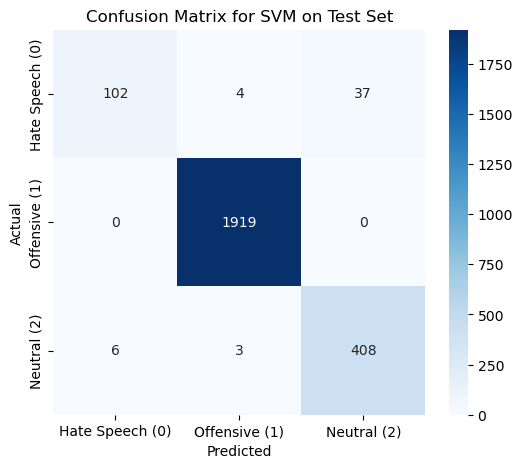

In [130]:
# Confusion Matrix

logging.info("Generating confusion matrix for the test set...")

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate Speech (0)', 'Offensive (1)', 'Neutral (2)'],
            yticklabels=['Hate Speech (0)', 'Offensive (1)', 'Neutral (2)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f"Confusion Matrix for {best_model_name} on Test Set")
plt.show()

2025-01-25 23:50:13,826 - INFO - Plotting ROC curves for each class...


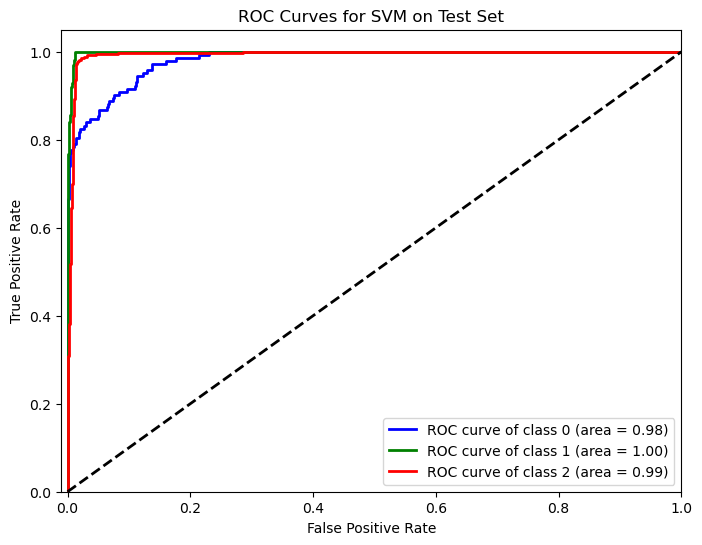

In [132]:
logging.info("Plotting ROC curves for each class...")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarizing the output
y_test_binarized = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test_binarized.shape[1]

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curves for {best_model_name} on Test Set")
plt.legend(loc="lower right")
plt.show()

In [136]:
# Model Deployment
# Saving the Pipeline

indices = np.argsort(np.abs(svd.components_).sum(axis=0))[-100:]  # Top 100 indices

best_model_name = "SVM"  
best_model = tuned_models[best_model_name]

logging.info(f"Best model selected: {best_model_name}")

# Saving the Pipeline Components
logging.info("Saving the pipeline components for deployment...")

# Saving TF-IDF Vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
logging.info("Saved TF-IDF Vectorizer as 'tfidf_vectorizer.pkl'.")

# Saving Truncated SVD Transformer
joblib.dump(svd, "svd_transform.pkl")
logging.info("Saved Truncated SVD as 'svd_transform.pkl'.")

# Saving Top Indices (Feature Selection)
joblib.dump(indices[:100], "svd_top_features.pkl")  
logging.info("Saved Top Feature Indices as 'svd_top_features.pkl'.")

# Saving Best Model
joblib.dump(best_model, f"best_model_{best_model_name}.pkl")
logging.info(f"Saved Best Model as 'best_model_{best_model_name}.pkl'.")


2025-01-25 23:53:03,884 - INFO - Best model selected: SVM
2025-01-25 23:53:03,885 - INFO - Saving the pipeline components for deployment...
2025-01-25 23:53:04,339 - INFO - Saved TF-IDF Vectorizer as 'tfidf_vectorizer.pkl'.
2025-01-25 23:53:04,348 - INFO - Saved Truncated SVD as 'svd_transform.pkl'.
2025-01-25 23:53:04,350 - INFO - Saved Top Feature Indices as 'svd_top_features.pkl'.
2025-01-25 23:53:04,357 - INFO - Saved Best Model as 'best_model_SVM.pkl'.


In [162]:
# Deployment Function to Predict New Tweets # Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the function for cleaning text during inference
def clean_text_inference(txt):
    """
    Cleans the input text in the same way as training data.
    """
    txt = txt.lower()  # Convert to lowercase
    txt = re.sub(r"http\S+|www\S+|https\S+", '', txt)  # Remove URLs
    txt = re.sub(r"[^\w\s]", '', txt)  # Remove punctuation
    tokens = txt.split()  # Tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize and remove stopwords
    return " ".join(tokens)

# Define the prediction function
def predict_new_tweet(raw_text):
    """
    Predicts the class of a new tweet using the saved pipeline components.
    """
    # Loading saved components
    loaded_tfidf = joblib.load("tfidf_vectorizer.pkl")
    loaded_svd = joblib.load("svd_transform.pkl")
    loaded_model = joblib.load(f"best_model_{best_model_name}.pkl")
    
    # Ensuring TF-IDF vectorizer uses the same vocabulary
    loaded_tfidf.fixed_vocabulary_ = True
    
    # Cleaning the text
    processed_txt = clean_text_inference(raw_text)
    
    # Transforming the input text using TF-IDF
    vec = loaded_tfidf.transform([processed_txt])
    print(f"TF-IDF Shape Before Padding: {vec.shape}")
    
    # Padding or trim ming the TF-IDF matrix to match the SVD's expected input size
    if vec.shape[1] < loaded_svd.n_features_in_:
        # Adding zero columns to match the SVD's input size
        padding = sp.csr_matrix((vec.shape[0], loaded_svd.n_features_in_ - vec.shape[1]))
        vec = hstack([vec, padding])
    elif vec.shape[1] > loaded_svd.n_features_in_:
        # Trim excess columns if more features are present
        vec = vec[:, :loaded_svd.n_features_in_]

    print(f"TF-IDF Shape After Padding: {vec.shape}")
    
    # Applying Truncated SVD to reduce dimensionality
    reduced = loaded_svd.transform(vec)
    print(f"SVD Reduced Shape: {reduced.shape}")
    
    # Using the reduced features directly for prediction
    prediction = loaded_model.predict(reduced)
    return prediction[0]

# Testing the Deployment Function
logging.info("Testing prediction on sample tweets:")
sample_tweets = [
    "I absolutely hate these people!",
    "What a fantastic day to enjoy with friends.",
    "Go away you annoying individual."
]

for tweet in sample_tweets:
    pred_class = predict_new_tweet(tweet)
    logging.info(f"Tweet: '{tweet}' => Predicted Class: {pred_class}")
    print(f"Tweet: '{tweet}' => Predicted Class: {pred_class}")

2025-01-26 00:30:06,005 - INFO - Testing prediction on sample tweets:
2025-01-26 00:30:06,254 - INFO - Tweet: 'I absolutely hate these people!' => Predicted Class: 2
2025-01-26 00:30:06,444 - INFO - Tweet: 'What a fantastic day to enjoy with friends.' => Predicted Class: 2


TF-IDF Shape Before Padding: (1, 5000)
TF-IDF Shape After Padding: (1, 5004)
SVD Reduced Shape: (1, 100)
Tweet: 'I absolutely hate these people!' => Predicted Class: 2
TF-IDF Shape Before Padding: (1, 5000)
TF-IDF Shape After Padding: (1, 5004)
SVD Reduced Shape: (1, 100)
Tweet: 'What a fantastic day to enjoy with friends.' => Predicted Class: 2


2025-01-26 00:30:06,580 - INFO - Tweet: 'Go away you annoying individual.' => Predicted Class: 2


TF-IDF Shape Before Padding: (1, 5000)
TF-IDF Shape After Padding: (1, 5004)
SVD Reduced Shape: (1, 100)
Tweet: 'Go away you annoying individual.' => Predicted Class: 2
